In [7]:
import os
import sys
import csv
import copy
import random
import itertools
from operator import itemgetter
from collections import defaultdict
import pprint

# Make sure you've got Numpy and Scipy installed:
import numpy as np
import scipy
import scipy.spatial.distance
from numpy.linalg import svd

# For visualization:
import tsne # See http://lvdmaaten.github.io/tsne/#implementations
import matplotlib.pyplot as plt

# For clustering in the 'Word-sense ambiguities' section:
from sklearn.cluster import AffinityPropagation

In [ ]:
%matplotlib inline

## Distributional Matrices

We can start by creating a dictionary $d$ that can be used to map word-pairs to counts. Everytime a pair of words $w$ and $w^\prime$ occur, we can increment a counter associated with each pair $d[w,w^\prime]$ by $1$. Using these count dictionary we can then create our vocabulary $V$, an ordered list of words types.

We can then create a matrix, $M$, of dimensions $|V|$ x $|V|$. Each $M[i,j]$ is filled with the counts contained in $d[w_i,w_j]$.

These co-occurence matrices have been provided with this example. We can import them with the _build_ function seen below.

In [3]:
# Build method to import co-occurence matrices

def build(src_filename, delimiter=',', header=True, quoting=csv.QUOTE_MINIMAL):    
    reader = csv.reader(file(src_filename), delimiter=delimiter, quoting=quoting)
    colnames = None
    if header:
        colnames = reader.next()
        colnames = colnames[1: ]
    mat = []    
    rownames = []
    for line in reader:        
        rownames.append(line[0])            
        mat.append(np.array(map(float, line[1: ])))
    return (np.array(mat), rownames, colnames)


We can now read in the example co-occurency matrices for later. We will be using the IMDB moview review dataset for these examples.


In [8]:
# Import word <-> word co-occurence matrix
ww = build('distributedwordreps-data/imdb-wordword.csv')

#Import w <-> document co-occurence matrix
wd = build('distributedwordreps-data/imdb-worddoc.csv')

In [9]:
# Example of counts of first words in the document which happen to be two exclamation marks

print("Word co-occurences : " + ww[1][0] + ", and, " + ww[2][0])

print "Count : " + str(ww[0][0][0])

Word co-occurences : !, and, !
Count : 343744.0


In [6]:
# Load GloVe vectors as well

glv = build('distributedwordreps-data/glove.6B.50d.txt', delimiter=' ', header=False, quoting=csv.QUOTE_NONE)

# Vector Comparisons

For the most part we are interested in measuring the _distance_ between two vectors. The general idea of vector comparisons using distance is that words that are semantically similar should be closer together in the vector spaces we build, and symantically unrelated words should be further apart.

The scipy library has a lot of vector comparison models methods, and for the purposes of our work here we'll be using this library as a supporting implementation of these methods.

### Euclidean Distance

The first comparison methodology we'll look at is Euclidean Distance. To find this distance, 

The equation to find the Euclidean Distance between vectors $u$ and $v$ of $n$ dimensions is below :

$$\sqrt{\sum_{i=1}^{n} |u_{i}-v_{i}|^2}$$


In two dimensions, this corresponds to the length of the direct most line between the two points.

Below is a method to define that function :

In [10]:
# method to compute euclidean distance
# we exploit a method already defined in scipy

def euclidean(u, v):
    return scipy.spatial.distance.euclidean(u, v)

Here I create a small toy array (matrix) for use within our examples.

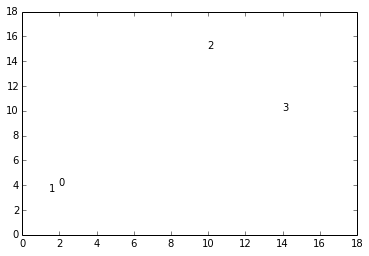

In [87]:
# Two dimensional vector embedding in two dimensional space to show 
# how we can measure the distance between two vectors in 2 space

ABC = np.array([
    [ 2.0,  4.0],  # 0
    [ 1.50,  3.50],# 1
    [10.0, 15.0],  # 2
    [14.0, 10.0]]) # 3

def plot_ABC(m):
    plt.plot(m[:,0], m[:,1], marker='', linestyle='')
    plt.xlim([0,np.max(m)*1.2])
    plt.ylim([0,np.max(m)*1.2])
    for i, x in enumerate(['0','1','2','3']):
        plt.annotate(x, m[i,:])

plot_ABC(ABC)

In [78]:
#Measure the distance between vectors A and B in matrix ABC
euclidean(ABC[0], ABC[1])

0.70710678118654757

In [64]:
#Measure the distance between vectors B and C in matrix ABC
euclidean(ABC[0], ABC[1])

0.0

## Vector Length

Euclidean distance measures the difference between two vector lengths, as shown the in the equation above. We're also able to find the length of a single vector, for use in later examples, as well by using the following equation :

$$\|u\| = \sqrt{\sum_{i=1}^{n} u_{i}^{2}}$$

We use the numpy library sqrt and dot product methods within the library shown below.

In [16]:
def vector_length(u):
    return np.sqrt(np.dot(u, u))

## Length Normalization

When working with datasets that have large(r), variation in the size of the datapoints that are used can skew the actual distance measured between vectors. Below we define a normalization function that will normalize each vector according to its length.

When normalizing all vectors according to their length, we can see in the plot below that this changes the representation of the data quite and bit and actually brings vector A and B closer together on the plot, showing their stronger similarity than say vectors B and C, or A and C.

In [ ]:
def length_norm(u):
    return  u / vector_length(u)

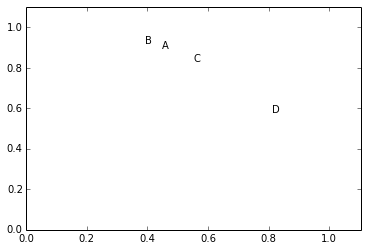

In [79]:
plot_ABC(np.array([length_norm(row) for row in ABC]))


### Cosine Distance

The cosine distance takes the overall vector length into account, meaning we don't have to run the vector_length() method over the vectors before calculation, and measure the angle between the two vectors. This is all captured within the Cosine Distance measurement function that is seen below :

$$1 - \left(\frac{\sum_{i=1}^{n} u_{i} \cdot v_{i}}{\|u\|\cdot \|v\|}\right)$$

The result is the same as first normalizing the vectors according to their length, vector_length(), and then computing the Euclidean distance between the two.

In [95]:
def cosine(u, v):
    # Use scipy's method:
    return scipy.spatial.distance.cosine(u, v)

In [88]:
cosine(ABC[1],ABC[3])

0.14521248477827109

## Distributional Neighbors

This functional is an investigational aide and allows us to use the similarity functions defined above over the IMDB dataset that we've previously loaded.

In [91]:
def neighbors(word=None, mat=None, rownames=None, distfunc=cosine):
    if word not in rownames:
        raise ValueError('%s is not in this VSM' % word)
    w = mat[rownames.index(word)]
    dists = [(rownames[i], distfunc(w, mat[i])) for i in xrange(len(mat))]
    return sorted(dists, key=itemgetter(1), reverse=False)

Here we show an example of a word and their respective neighbors according to both cosine similarity and basic euclidean distance.

In [132]:
neighbors(word='superb', mat=ww[0], rownames=ww[1], distfunc=cosine)[: 10]

[('superb', 0.0),
 ('excellent', 0.0026965023912962627),
 ('outstanding', 0.0027344413235226295),
 ('beautifully', 0.0027345163104325332),
 ('brilliant', 0.0027888643627086429),
 ('performances', 0.0028333319740448948),
 ('perfectly', 0.0028436893209292657),
 ('memorable', 0.0028935533453889883),
 ('cinematography', 0.0029206920379420964),
 ('wonderfully', 0.0029473105937050104)]

In [133]:
neighbors(word='superb', mat=ww[0], rownames=ww[1], distfunc=euclidean)[: 10]

[('superb', 0.0),
 ('familiar', 1448.8919904533948),
 ('violent', 1630.3723501090174),
 ('follows', 1647.0276257549538),
 ('convincing', 1701.2260284865147),
 ('pace', 1748.1195611284716),
 ('recent', 1769.8525362300668),
 ('amount', 1783.1822677449436),
 ('impressive', 1789.4510331383756),
 ('masterpiece', 1849.5091240650856)]

### GloVe representation

Here we can see that the GloVe vectors perform _very_ well, but they are based on much more than a simple raw count of occurences in the text.

In [134]:
neighbors(word='superb', mat=glv[0], rownames=glv[1], distfunc=cosine)[: 10]

[('superb', 2.2204460492503131e-16),
 ('brilliant', 0.15809110259014747),
 ('impressive', 0.19352861376442654),
 ('masterful', 0.22871323564771928),
 ('excellent', 0.22928471014596696),
 ('volley', 0.24414121851443737),
 ('deft', 0.24755074890723616),
 ('dazzling', 0.26191184828838354),
 ('score', 0.26231230884814061),
 ('scoring', 0.26641165920991983)]

## Matrix Reweighting

Taking a look at the similarity measurements listed above, we can see that they offer some insight into the embedded context contained within written language, but they're not quite as accurate as we would like them to be. This is where matrix reweighting comes into play. The goal of matrix reweighting is to amplify the important, trustworthy and unusual representations found within language, and de-emphasize the unimportant, and untrustworthy representations.

### Normalization

Here we see another form of normalization that can be applied to the data. With length_norm() seen above, we normalize using the vector_length(). There are other ways that we can normalize the datasets as well, such as each row by the sum of its values, which turns each row into a probability distribution over the columns :

In [135]:
def prob_norm(u):
    return u / np.sum(u)

These normalization measures are insensitive to the magnitude of the underlying counts, which can cause problems in larger datasets. An example is [1,10] is vastly different than [1000, 10000], and those differences will end up being obscured by these normalization procedures.

## Pointwise Mutual Information

This brings us to something called Pointwise Mutual Information (PMI), which can help address the issue of the ignorance of the magnitude of the counts within the previous normalization functions. This is the measure between a pair of discreet outcomes $x$ and $y$, as defined as :

$$PMI(x,y) = log \frac{P(x,y)}{P(x) \cdot P(y)}$$

$PMI(w,c)$ measures the association between a word $w$ and a context $c$ by calculating the log of the ratio between their joint probability (the frequency in which they occur together) and their marginal probabilities (the frequency with which they occur independently).

This can be shown by considering the actual number of observations within a corpus :

$$PMI(w,c) = log \frac{\#(w,c) \cdot |D|}{\#(w) \cdot \#(c)}$$

The challenge with PMI arises when we compute $M^{PMI}$. This leaves us with rows containing many entries of word-context pairs $(w,c)$ that were never observed in the corpus, for which $PMI(w,c) = log 0 = -\infty$. This leaves the matrix 'ill-defined'. We could do potentially smooth over the probabilities using something like a Dirichlet prior by adding a small "fake" count to the underlying counts matrix. But this leaves us with, still, a very dense matrix to deal with.

An alternative approach would be to replace $M^{pmi}$ with $M_0^{PMI}$, in which $PMI(w,c) = 0$ in all cases $\#(w,c) = 0$, which results in a sparse matrix.

When approaching this problem, we understand that there are "bad" (uncorrelated) word-context pairs, which are represented with negative matrix entries, and replacing $M^{PMI}$ with $M_0^{PMI}$ will leave non-existent word context pairs with 0 entries in the matrix, which would rate them "better" than resulting negative entries from the real $M^{PMI}$.

In [136]:
#PMI example
def pmi(mat=None, rownames=None):
    # Create a joint probability table
    p = mat / np.sum(mat, axis=None)
    # Pre-compute column sums
    colprobs = np.sum(p, axis=0)
    # Vectorize this function so it can be applied rowwise
    np_pmi_log = np.vectorize((lambda x : _pmi_log(x, positive=positive)))
    p = np.array([np_pmi_log(row / (np.sum(row)*colprobs)) for row in p])
    return (p, rownames)
    